# Import packages and data

In [1]:
%%capture
!pip install bertopic umap hdbscan transformers anthropic openai tiktoken accelerate bitsandbytes adjustText peft==0.6.0

In [2]:
# Import packages
import pandas as pd
import matplotlib
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import time
from tqdm import tqdm
from adjustText import adjust_text
from scipy.stats import ttest_ind, sem
from scipy import stats
from Utils.utils_topic_modeling import (
    show_text_length,
    plot_grid_search_result,
    document_topic_matrix,
    get_combined_topic_info,
    topic_distribution,
    generate_target_audience,
    classification_by_audience,
    similarity_check,
    merge_and_classify,
    plot_pork_policy_ratios,
    plot_change,
    perform_t_test,
    visualization_dot_plot,
    visualization
)

# Bertopic
import tensorflow as tf
tf.config.optimizer.set_jit(True)
tf.config.optimizer.set_experimental_options({'auto_mixed_precision': True})
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from transformers.pipelines import pipeline
from transformers import AutoTokenizer, AutoModelForMaskedLM
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.backend import OpenAIBackend
from bertopic.representation import TextGeneration
from bertopic.representation import ZeroShotClassification
from bertopic.representation import KeyBERTInspired
from bertopic.representation import OpenAI

# sklearn
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from pprint import pprint

# OpenAI
import openai

# Gemini
from google.colab import userdata
import google.generativeai as genai

# Taiwan LLAMA
from torch import bfloat16
from transformers import BitsAndBytesConfig
import transformers
import accelerate
import bitsandbytes as bnb
from peft import PeftModel

# Claude
import anthropic

# Huggingface
import torch
from transformers import pipeline

## Assess to Google Drive

In [ ]:
from google.colab import drive
from google.colab import userdata
import numpy as np
from numpy import random
import os
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
CLAUDE_API_KEY = userdata.get('CLAUDE_API_KEY')
HUGGINGFACE_API_KEY = userdata.get('HUGGINGFACE_API_KEY')

# Set seed for reproduction
SEED = random.randint(100)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# Setup work directory
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Dissertation')
os.listdir() # overview the files

In [4]:
years = [1992, 1995, 1998, 2001, 2004, 2008, 2012, 2016, 2020, 2024]
df = pd.read_csv('Manifesto_Dataset.csv')

In [ ]:
df = df[df['SENTENCE'].notna()].reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39516 entries, 0 to 39515
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 39516 non-null  object 
 1   LNAME              39516 non-null  object 
 2   TH                 39516 non-null  int64  
 3   AREA               39516 non-null  object 
 4   PARTY              39516 non-null  object 
 5   PARTY_CODE         39516 non-null  int64  
 6   GENDER             39516 non-null  int64  
 7   INCUMBENT          39516 non-null  int64  
 8   EDUCATION          39516 non-null  object 
 9   ELE                39516 non-null  int64  
 10  VOTES              39516 non-null  int64  
 11  VOTER_TURNOUT      39516 non-null  float64
 12  CONTENT            39516 non-null  object 
 13  CONTENT_LENGTH     39516 non-null  int64  
 14  ENOUGH_VOTE        39516 non-null  bool   
 15  MAIN_PARTY_MEMBER  39516 non-null  bool   
 16  SERIOUS_CANDIDATE  395

In [ ]:
df.groupby('TH').size()

TH
2     3969
3     3580
4     4328
5     4641
6     3920
7     3713
8     2916
9     3912
10    4796
11    3741
dtype: int64

# Preprocess Manifesto Data

In [ ]:
df['SENTENCE'] = df['SENTENCE'].astype(str)
df['CLEAN_CONTENT'] = df['CLEAN_CONTENT'].astype(str)

In [ ]:
# ALL Manifestos
df['CONTENT_LENGTH'] = df.groupby('ID')['CONTENT'].transform(lambda x: x.apply(len))
print(f'There are {len(df)} documents in total.') # 39516

There are 39516 documents in total.


In [ ]:
# Serious candidates
print(f"There are {len(df[df['SERIOUS_CANDIDATE'] == 1])} policies that are raised by serious candidates.") # 33734 / 39516

There are 33734 policies that are raised by serious candidates.


## Document length count

Since the maximum token transformer can process is 512, make sure documents length would not longer than it.

Besides, I try to create at least 2 segmentations of each manifesto

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

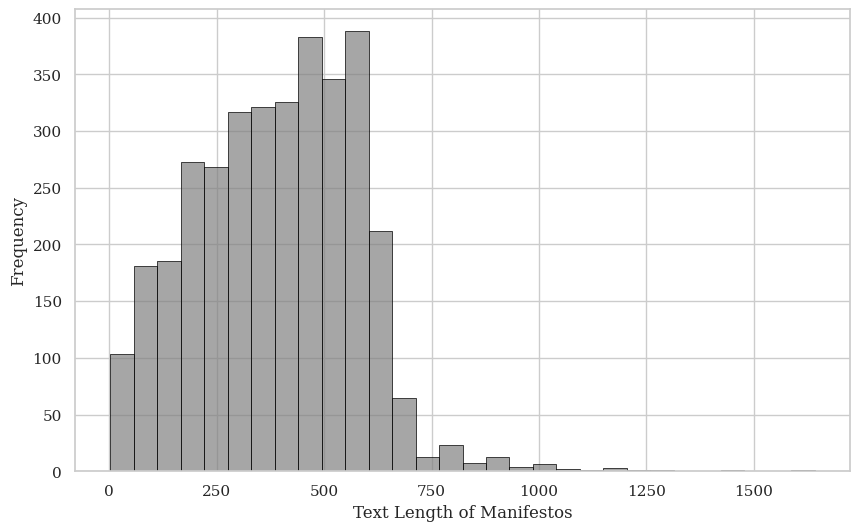

In [ ]:
text_length = df.groupby('ID')['CONTENT_LENGTH'].sum().reset_index()
show_text_length(text_length['CONTENT_LENGTH'], save=True)

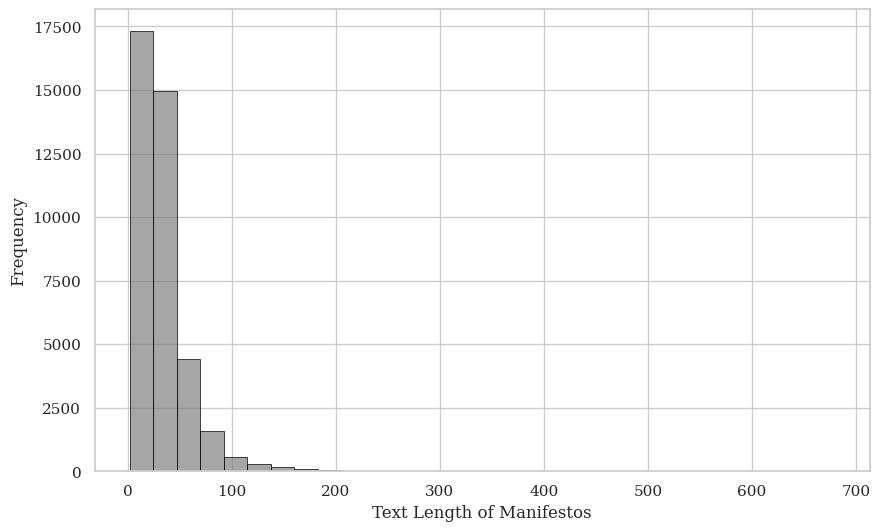

In [ ]:
show_text_length(df['CONTENT_LENGTH'], save=True)

# BERTopic model

In [ ]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

## Embedding Model

In [ ]:
from transformers.pipelines import pipeline

embedding_model = pipeline("feature-extraction", model="hfl/chinese-roberta-wwm-ext", device=device)

## Dimension Reduction

In [ ]:
# Dimension reduction
umap_model = UMAP(n_neighbors=10, n_components=2, min_dist=0.1, metric='cosine', random_state=SEED)

## Clustering

In [ ]:
# Clustering
hdbscan_model = HDBSCAN(min_cluster_size=25, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

## Vectorize

In [ ]:
vectorizer_model = CountVectorizer(max_df=0.99, min_df=0.005)

## Representation Model

In [ ]:
# Representation model fine-tuning using gpt-4-turbo
prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short topic label in the following format and use only traditional Chinese:
topic: <topic label>
"""

summarization_prompt = """
I have a topic that is described by the following keywords: [KEYWORDS]
In this topic, the following documents are a small but representative subset of all documents in the topic:
[DOCUMENTS]

Based on the information above, please give a description of this topic in the following format and use only traditional Chinese with no more than 15 words:
topic: <description>
"""

client = openai.OpenAI(api_key=OPENAI_API_KEY)
gpt_turbo= OpenAI(client, model="gpt-4-turbo", delay_in_seconds=4, chat=True, prompt=summarization_prompt, generator_kwargs={'top_p':0.95, 'temperature': 0.95})

representation_model = {
    "GPT": gpt_turbo,
}

## OPENAI

### Emedding

In [ ]:
# Corpus
documents = df["SENTENCE"].tolist()
batch_size = 96
all_embeddings = []
client = openai.OpenAI(api_key=OPENAI_API_KEY)

for i in range(0, len(documents), batch_size):
    batch = documents[i:i+batch_size]
    response = client.embeddings.create(input=batch, model="text-embedding-3-large") # 使用第三代模型
    batch_embeddings = [r.embedding for r in response.data]
    all_embeddings.extend(batch_embeddings)

embeddings = np.array(all_embeddings)

In [ ]:
embedding_df = pd.DataFrame(embeddings)
embedding_df.to_csv('Embedding_OPENAI_SENTENCE.csv', index=False, header=None)

### Model

In [ ]:
# Embedding_OPENAI.csv is for column CLEAN_CONTENT
# Embedding_OPENAI_SENTENCE.csv is for column SENTENCE
embedding = pd.read_csv('Embedding_OPENAI_SENTENCE.csv', header=None)

In [ ]:
print(embedding.shape)
embeddings = embedding.to_numpy()

(39516, 3072)


In [ ]:
# Now pass the embeddings to BERTopic
topic_model = BERTopic(language="Chinese",
                       verbose=True,
                       calculate_probabilities=True,
                       umap_model=umap_model, # Dimention reduction
                       hdbscan_model=hdbscan_model, # Clustering
                       vectorizer_model=vectorizer_model, # Vectorize
                       # n_gram_range=(1)
                       )

documents = df["SENTENCE"].tolist() # SENTENCE 有斷詞處理
topics, probs = topic_model.fit_transform(documents, embeddings)

2024-05-05 05:20:01,120 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-05-05 05:20:49,802 - BERTopic - Dimensionality - Completed ✓
2024-05-05 05:20:49,806 - BERTopic - Cluster - Start clustering the reduced embeddings
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
2024-05-05 05:21:34,907 - BERTopic - Cluster - Completed ✓
2024-05-05 05:21:34,918 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-05-05 05:21:36,364 - BERTopic - Representation - Completed ✓


# LDA Model

## Vectorizer

In [ ]:
df = df[df['TOKEN'].notna()].reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39504 entries, 0 to 39503
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 39504 non-null  object 
 1   LNAME              39504 non-null  object 
 2   TH                 39504 non-null  int64  
 3   AREA               39504 non-null  object 
 4   PARTY              39504 non-null  object 
 5   PARTY_CODE         39504 non-null  int64  
 6   GENDER             39504 non-null  int64  
 7   INCUMBENT          39504 non-null  int64  
 8   EDUCATION          39504 non-null  object 
 9   ELE                39504 non-null  int64  
 10  VOTES              39504 non-null  int64  
 11  VOTER_TURNOUT      39504 non-null  float64
 12  CONTENT            39504 non-null  object 
 13  CONTENT_LENGTH     39504 non-null  int64  
 14  ENOUGH_VOTE        39504 non-null  bool   
 15  MAIN_PARTY_MEMBER  39504 non-null  bool   
 16  SERIOUS_CANDIDATE  395

In [ ]:
import uuid
num_rows = len(df)
uuids = [str(uuid.uuid4()) for _ in range(num_rows)]
df['ID_OF_PART'] = uuids

In [ ]:
data = df.TOKEN.values.tolist()
print(data[:1])

['建請 政府 落實 農民 提升 農民 生活 品質']


In [ ]:
# remove tokens that appeared more than 99% and less than 0.04% of the manifestos
vectorizer = CountVectorizer(analyzer='word',
                             max_df=0.99,
                             min_df=int(0.0004 * len(data)))
data_vectorized = vectorizer.fit_transform(data)
print(data_vectorized.shape)

(39504, 3523)


## Tuning Hyperparameters

In [ ]:
# Define Search Param
n_topics = list(range(152, 166, 1))
search_params = {'n_components': n_topics, 'learning_decay': [.3], 'batch_size': [128]}

# Init the Model
lda = LatentDirichletAllocation(max_iter=10,               # Max learning iterations
                                learning_method='batch',
                                random_state=SEED,         # Random state
                                evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                n_jobs = -1,               # Use all available CPUs
                                )


model = GridSearchCV(lda, param_grid=search_params, cv=3, verbose=3)
model.fit(data_vectorized)

Fitting 3 folds for each of 14 candidates, totalling 42 fits
[CV 1/3] END batch_size=128, learning_decay=0.3, n_components=152;, score=-1161166.936 total time=  15.8s
[CV 2/3] END batch_size=128, learning_decay=0.3, n_components=152;, score=-1113026.524 total time=  13.8s
[CV 3/3] END batch_size=128, learning_decay=0.3, n_components=152;, score=-1365191.245 total time=  14.3s
[CV 1/3] END batch_size=128, learning_decay=0.3, n_components=153;, score=-1164642.062 total time=  14.2s
[CV 2/3] END batch_size=128, learning_decay=0.3, n_components=153;, score=-1117888.834 total time=  14.1s
[CV 3/3] END batch_size=128, learning_decay=0.3, n_components=153;, score=-1368062.979 total time=  13.9s
[CV 1/3] END batch_size=128, learning_decay=0.3, n_components=154;, score=-1158125.661 total time=  13.9s
[CV 2/3] END batch_size=128, learning_decay=0.3, n_components=154;, score=-1114925.169 total time=  14.2s
[CV 3/3] END batch_size=128, learning_decay=0.3, n_components=154;, score=-1373974.203 tota

GridSearchCV(cv=3,
             estimator=LatentDirichletAllocation(n_jobs=-1, random_state=23),
             param_grid={'batch_size': [128], 'learning_decay': [0.3],
                         'n_components': [152, 153, 154, 155, 156, 157, 158,
                                          159, 160, 161, 162, 163, 164, 165]},
             verbose=3)

In [ ]:
# Best Model
best_lda_model = model.best_estimator_

print("Best Model's Params: ", model.best_params_)
print("Best Log Likelihood Score: ", model.best_score_)
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'batch_size': 128, 'learning_decay': 0.3, 'n_components': 152}
Best Log Likelihood Score:  -1213128.2350268383
Model Perplexity:  1469.6217846222528


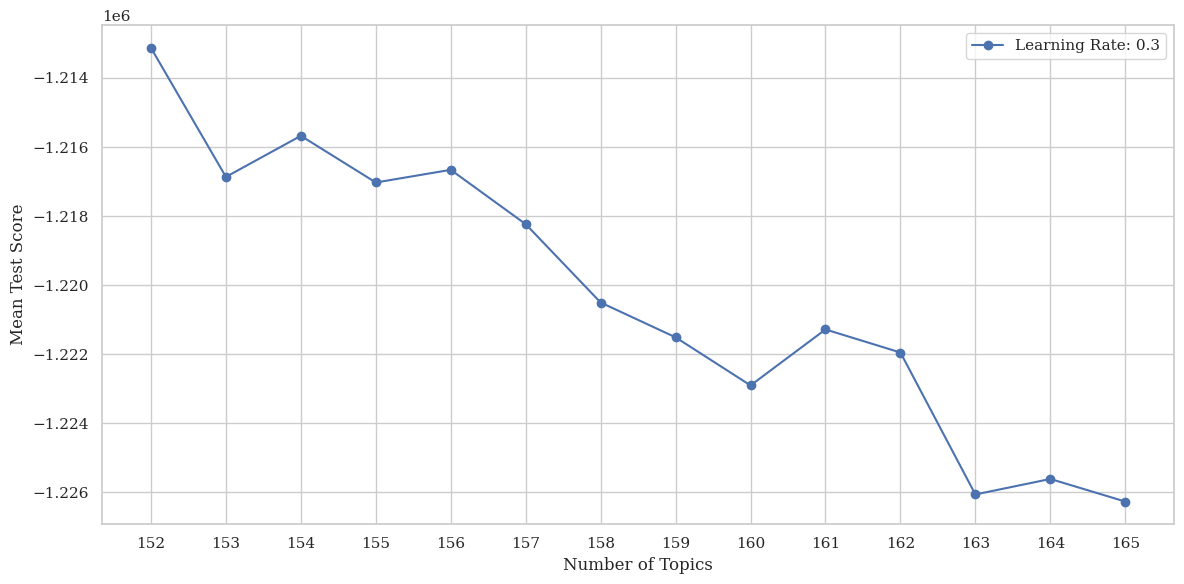

In [ ]:
plot_grid_search_result(model, save=True)

## Model Setting

In [ ]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=152,           # Number of topics
                                      max_iter=12,               # Max learning iterations
                                      learning_method='batch',
                                      batch_size=128,
                                      learning_decay=0.3,
                                      random_state=SEED,         # Random state
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      verbose=3
                                     )

In [ ]:
lda_model.fit_transform(data_vectorized)
print(lda_model)  # Model attributes

print("\n")
print("Log Likelihood: ", lda_model.score(data_vectorized))
print("Perplexity: ", lda_model.perplexity(data_vectorized))
pprint(lda_model.get_params())

iteration: 1 of max_iter: 12
iteration: 2 of max_iter: 12
iteration: 3 of max_iter: 12
iteration: 4 of max_iter: 12
iteration: 5 of max_iter: 12
iteration: 6 of max_iter: 12
iteration: 7 of max_iter: 12
iteration: 8 of max_iter: 12
iteration: 9 of max_iter: 12
iteration: 10 of max_iter: 12
iteration: 11 of max_iter: 12
iteration: 12 of max_iter: 12
LatentDirichletAllocation(learning_decay=0.3, max_iter=12, n_components=152,
                          random_state=46, verbose=3)


Log Likelihood:  -3007183.3497111876
Perplexity:  1505.7293195377595
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.3,
 'learning_method': 'batch',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 12,
 'mean_change_tol': 0.001,
 'n_components': 152,
 'n_jobs': None,
 'perp_tol': 0.1,
 'random_state': 46,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 3}


In [ ]:
df_document_topic, topicnames = document_topic_matrix(df_=df, lda_model=lda_model, data=data_vectorized)
df_document_topic

,0,1,2,3,4,5,6,7,8,9,...,144,145,146,147,148,149,150,151,Dominant_topic,ID_OF_PART
0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,68,5cd985a9-8ce6-489f-9923-837e97820404
1,0.0,0.00,0.0,0.00,0.24,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,127,9a8d9736-a142-49b7-8356-c670fe2c8dcc
2,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,46,73a67938-bf05-4d4e-87fc-3de92a1230c1
3,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.35,0.0,150,407899d9-517b-40d3-b44b-36bb96290bdf
4,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,45,62e6e539-e414-4e81-81c4-14b43d99eb73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39499,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,40,271fa800-0c60-4ab1-8569-569b06813d4f
39500,0.0,0.00,0.0,0.00,0.00,0.08,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.14,0.0,0.0,0.00,0.0,39,88d20345-d0e3-4843-ad94-10dbf119a356
39501,0.0,0.00,0.0,0.18,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.1,0.0,0.00,0.0,0.0,0.00,0.0,137,3407b522-eeed-41f1-8df3-4609a64aa1d7
39502,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,56,d967688c-80cd-4300-8d05-7b426d151ff7


In [ ]:
topic_info = get_combined_topic_info(vectorizer, lda_model, df_document_topic, df)
topic_info

,Topic,Keywords,Representative_Docs
0,0,"[預算, 政府, 編列, 監督, 完全, 中央, 基隆河, 本土化, 遏止, 中學]",[預算 主張 直接 支配 政府 預算 直接 支配 政府 預算 分配 申報 綜合 所得稅 申報...
1,1,"[基層, 人力, 扶助, 毒品, 移民, 素質, 官員, 淨化, 消防, 配偶]","[陸配 外籍 配偶 取得 身分證 移民 鬆綁 親權 親戚 探親權, 陸配 外籍 配偶 取得 ..."
2,2,"[文化, 多元, 在地, 活動, 藝術, 方案, 藝文, 推動, 深化, 豐富]","[持續 辦理 藝文 下鄉 展演 活動, 持續 辦理 藝文 下鄉 展演 活動, 推動 住民 在..."
3,3,"[都市, 計畫, 更新, 地區, 停車場, 推動, 改善, 爭取, 排水, 停車]","[加速 推動 都市 更新 浮洲區 盡快 都市 計畫 興建 汙水 下水道, 全面 整治 河海堤..."
4,4,"[權益, 勞工, 保障, 維護, 勞資, 爭取, 確保, 勞動, 政策, 立法]","[督促 政府 精省 省府 員工 權益 保障 維護 務必 落實, 修法 保障 勞工 權益 健全..."
...,...,...,...
147,147,"[發展, 經濟, 區域, 永續, 均衡, 促進, 綠色, 推動, 能源, 政策]","[健全 國家 經濟 發展 督促 政府, 支持 政府 建立 非核家園, 發展 綠色 能源 綠色..."
148,148,"[桃園, 乾淨, 美麗, 承諾, 搶救, 陽光法案, 政府, 航空城, 權責, 全體]","[監督 落實 航空城 承諾, 加強 掃黑 肅貪 査賄, 新店 老店 新店 老店 新店 老店]"
149,149,"[人才, 培育, 充實, 主體, 紮根, 優秀, 軟硬體, 警察, 專業, 文教]","[加強 教練 運動員 培育, 培育 眾多 優秀 人才 以為 日後 服務 家鄉 國家, 加強 ..."
150,150,"[福利, 老人, 兒童, 殘障, 增進, 社會, 政策, 照顧, 落實, 同胞]","[健全 福利 政策 照顧 殘障 同胞 輔導 就學 就業, 落實 老人 婦女 兒童 殘障 同胞..."


In [ ]:
df_topic_distribution = topic_distribution(df_document_topic)
df_topic_distribution

,Topic,Document Count
0,4,902
1,32,815
2,100,806
3,11,722
4,16,697
...,...,...
147,67,66
148,81,66
149,133,59
150,93,59


# Post Processing

In [ ]:
# Overview topics
topic_info = topic_model.get_topic_info()
topic_info

,Topic,Count,Name,Representation,Representative_Docs
0,-1,12315,-1_臺灣_教育_發展_文化,"[臺灣, 教育, 發展, 文化, 交通, 建設, 觀光, 爭取, 推動, 政府]",[監督 政府 創造 就業 機會 降低 失業率 配合 產業 發展 政策 全面 解決 失業 問題...
1,0,2072,0_婦女_弱勢_福利_殘障,"[婦女, 弱勢, 福利, 殘障, 婦幼, 團體, 照顧, 社會, 兩性, 老人]","[保障 弱勢 爭取 婦女 兒童 殘障 老人 更多 社會 福利 弱勢 團體 保障, 落實 老人..."
2,1,1133,1_問政_立委_立法委員_參選,"[問政, 立委, 立法委員, 參選, 服務, 專業, 民意, 政治, 選民, 政見]","[創造 優質 政治 文化 專業 理性 問政, 參選 主要 政見 理性 問政 繼續 推動 國會..."
3,2,1124,2_中小企業_投資_產業_經濟,"[中小企業, 投資, 產業, 經濟, 升級, 企業, 競爭力, 環境, 轉型, 傳統]","[協助 中小企業 產業 升級 技術 升級 臺灣, 改善 投資 環境 協助 中小企業 提升 國..."
4,3,1092,3_農業_農民_農地_農產品,"[農業, 農民, 農地, 農產品, 產銷, 農漁民, 漁民, 買賣, 價格, 漁業]",[農業 政策 農地 自由 買賣 開發 閒置 養殖 用地 獎勵 補助 農業 生產 保障 農產品...
...,...,...,...,...,...
161,160,27,160_作主_人民_主人_統治,"[作主, 人民, 主人, 統治, 勢力, 權稱為, 政治, 底層, 行使, 治權]","[人民 作主 政治, 人民 作主 政治, 人民 作主 政治]"
162,161,26,161_地球_義工_拯救_投票,"[地球, 義工, 拯救, 投票, 太陽, 重大, 公民, 議題, 哥白尼, 地平]","[環保 義工 拯救 地球, 環保 義工 拯救 地球, 環保 義工 拯救 地球]"
163,162,26,162_涉貪_議長_消滅_殭屍,"[涉貪, 議長, 消滅, 殭屍, 林o世, 冰山一角, 臺濟世, 時力, 廖o棟, 徐o明]",[消滅 貪腐 消滅 貧窮 行政院 祕書長 涉貪 林O世 立委 涉貪 蘇O清 廖O棟 徐O明 ...
164,163,25,163_壯大_政局_穩定_鞏固,"[壯大, 政局, 穩定, 鞏固, 振興, 臺灣, 民主, 多點, 經濟, 前總統]","[穩定 政局 振興 經濟 鞏固 民主 壯大 臺灣, 穩定 政局 振興 經濟 鞏固 民主 壯大..."


In [ ]:
topic_dict = {}
for i in range(topic_info.shape[0]-1):
    # 注意get_topic返回的是一個tuple列表，我們只需要每個tuple的第一個元素，即關鍵字本身
    keywords = topic_model.get_topic(i)
    words = []
    for word in keywords:
        words.append(word[0])
    topic_dict['Topic' + str(i)] = words

topic_df = pd.DataFrame(topic_dict)
topic_df

In [ ]:
topic_model.visualize_barchart(top_n_topics=12)

In [ ]:
topic_model.visualize_documents(documents, hide_document_hover=True,
                                embeddings=embeddings, hide_annotations=True)

In [ ]:
topic_model.visualize_topics()

## Fine-tuning Representation

In [ ]:
topic_model.update_topics(docs=documents, representation_model=representation_model)

100%|██████████| 166/166 [16:42<00:00,  6.04s/it]


In [ ]:
topic_info_gpt = topic_model.get_topic_info()
topic_info_gpt.head(5)

,Topic,Count,Name,Representation,GPT,Representative_Docs
0,-1,12315,-1_臺灣_教育_發展_文化,"[臺灣, 教育, 發展, 文化, 交通, 建設, 觀光, 爭取, 推動, 政府]",[推動臺灣教育、文化發展及交通建設，政府積極爭取觀光提升生活品質。],[監督 政府 創造 就業 機會 降低 失業率 配合 產業 發展 政策 全面 解決 失業 問題...
1,0,2072,0_婦女_弱勢_福利_殘障,"[婦女, 弱勢, 福利, 殘障, 婦幼, 團體, 照顧, 社會, 兩性, 老人]",[關注弱勢群體福利，強化婦女、兒童、老人及殘障者照顧與權益保障。],"[保障 弱勢 爭取 婦女 兒童 殘障 老人 更多 社會 福利 弱勢 團體 保障, 落實 老人..."
2,1,1133,1_問政_立委_立法委員_參選,"[問政, 立委, 立法委員, 參選, 服務, 專業, 民意, 政治, 選民, 政見]",[立法委員參選，專注問政、民意反映，致力政治改革及提升服務品質。],"[創造 優質 政治 文化 專業 理性 問政, 參選 主要 政見 理性 問政 繼續 推動 國會..."
3,2,1124,2_中小企業_投資_產業_經濟,"[中小企業, 投資, 產業, 經濟, 升級, 企業, 競爭力, 環境, 轉型, 傳統]",[促進中小企業產業升級，改善投資環境，增強國際競爭力及就業機會。],"[協助 中小企業 產業 升級 技術 升級 臺灣, 改善 投資 環境 協助 中小企業 提升 國..."
4,3,1092,3_農業_農民_農地_農產品,"[農業, 農民, 農地, 農產品, 產銷, 農漁民, 漁民, 買賣, 價格, 漁業]",[探討農業發展、農民福利與農產品產銷策略，確保農民收益及農地合理利用。],[農業 政策 農地 自由 買賣 開發 閒置 養殖 用地 獎勵 補助 農業 生產 保障 農產品...


## Target Audience Generation

In [ ]:
generation_config = {
    "candidate_count": 1,
    "max_output_tokens": 256,
    "temperature": 0.95,
    "top_p": 0.95,
    "top_k": 40,
    "repetition_penalty": 1.1
    }


In [ ]:
topic_info = generate_target_audience(df=topic_info_gpt, 
                                      model_name='Gemini', 
                                      config=generation_config,
                                      unit='policy',
                                      BERTopic=True
                                      )

Generating target audiences: 100%|██████████| 125/125 [17:19<00:00,  8.32s/it]


In [ ]:
topic_info = generate_target_audience(df=topic_info_gpt, 
                                      model_name='GPT', 
                                      config=generation_config,
                                      unit='policy',
                                      BERTopic=True
                                      )

In [ ]:
topic_info = generate_target_audience(df=topic_info_gpt, 
                                      model_name='Claude', 
                                      config=generation_config,
                                      unit='policy',
                                      BERTopic=True
                                      )

In [ ]:
import ast

# We use 廖達琪's standatd of classification
audience_list = ["全民", "軍公教", "台商", "老人", "婦女", "原住民", "族群(閩南、客家族群、眷村)", "外籍人士",
                 "學生", "中壯年", "青年", "兒童", "榮民", "勞工", "藝文人士", "工商企業", "醫療人員", "病人", "選手",
                 "公益團體(社福團體)", "專業人士", "社工員", "自由行旅客", "特殊技能人士", "弱勢(含性工作者、更生人、卡奴、腳踏車騎士)",
                 "僑民", "殘障(身心障礙)", "失業", "低收入戶", "中間選民", "投資者", "父母家長親子", "單親家庭",
                 "選任公務人員(議員、里長)", "農漁民", "網民", "地區居民"]

In [ ]:
topic_info = classification_by_audience(topic_info, audience_list)
topic_info.head(3)

Similarity of GPT vs. Claude: 0.822


,Topic,Keywords,Representative_Docs,Target_Audience_GPT,GPT_Explanation,Target_Audience_Claude,Claude_Explanation,PORK_GPT,PORK_Claude,PORK_AI
0,0,"[預算, 政府, 編列, 監督, 完全, 中央, 基隆河, 本土化, 遏止, 中學]",[預算 主張 直接 支配 政府 預算 直接 支配 政府 預算 分配 申報 綜合 所得稅 申報...,"[全民, 中學]",Target audience,[全民],Target,0,0,0
1,1,"[基層, 人力, 扶助, 毒品, 移民, 素質, 官員, 淨化, 消防, 配偶]","[陸配 外籍 配偶 取得 身分證 移民 鬆綁 親權 親戚 探親權, 陸配 外籍 配偶 取得 ...","[弱勢, 移民, 外籍人士, 原住民, 中低收入戶]",Target audience,"[婦女, 外籍人士]",Target,0,0,0
2,2,"[文化, 多元, 在地, 活動, 藝術, 方案, 藝文, 推動, 深化, 豐富]","[持續 辦理 藝文 下鄉 展演 活動, 持續 辦理 藝文 下鄉 展演 活動, 推動 住民 在...",[地區居民(公益團體(文化團體))],Target audience,"[公益團體(社福團體), 地區居民, 藝文人士]",Target,1,0,-1


In [ ]:
current_versions = 3
MODEL = 'LDA'
FILE_PATH = 'LDA'
topic_info.to_csv(f'Result/Result_V2/{FILE_PATH}/Result_v{current_versions}/topic_info_v{current_versions}.csv', encoding='utf-8-sig', index=False)

# Should be changed every time
df_new = pd.concat([df,df_document_topic[['ID_OF_PART', 'Dominant_topic']]], axis=1)
df_new.rename(columns={"Dominant_topic": f"Topic_v{current_versions}"}, inplace=True)
df_new.head(3)

,ID,LNAME,TH,AREA,PARTY,PARTY_CODE,GENDER,INCUMBENT,EDUCATION,ELE,...,MAIN_PARTY_MEMBER,SERIOUS_CANDIDATE,SENTENCE,TOKEN,CLEAN_CONTENT,WEIGHT,PART,ID_OF_PART,ID_OF_PART,Topic_v3
0,0b534f0b-eebc-43f2-8e8e-ea7a35bc3ced,張宗明_2,2,新竹縣,中國全民福利黨,20,1,0,99,0,...,False,0,建請 政府 落實 農民 保險 提升 農民 生活 品質,建請 政府 落實 農民 提升 農民 生活 品質,"、建請政府落實農民保險,提升農民生活品質。",0.144828,0.142857,5cd985a9-8ce6-489f-9923-837e97820404,5cd985a9-8ce6-489f-9923-837e97820404,68
1,0b534f0b-eebc-43f2-8e8e-ea7a35bc3ced,張宗明_2,2,新竹縣,中國全民福利黨,20,1,0,99,0,...,False,0,建全 農產 運銷 制度 保障 農民 權益,建全 農產 運銷 制度 保障 農民 權益,建全農產運銷制度;保障農民權益。,0.110345,0.142857,9a8d9736-a142-49b7-8356-c670fe2c8dcc,9a8d9736-a142-49b7-8356-c670fe2c8dcc,127
2,0b534f0b-eebc-43f2-8e8e-ea7a35bc3ced,張宗明_2,2,新竹縣,中國全民福利黨,20,1,0,99,0,...,False,0,全工 退休 失業 保險 制度 及早 實施 全民 保險,全工 退休 失業 制度 及早 實施 全民,"建全工退休、失業等保險制度,及早實施全民保險。",0.158621,0.142857,73a67938-bf05-4d4e-87fc-3de92a1230c1,73a67938-bf05-4d4e-87fc-3de92a1230c1,46


#### Save The Result

In [ ]:
# Save the results
topic_column_gpt = topic_model.get_document_info(df['SENTENCE'])
df_new = pd.concat([df, topic_column_gpt[['Topic']]], axis=1)
df_new.rename(columns={"Topic": f"Topic_v{current_versions}"}, inplace=True)
df_new.shape

(39516, 23)

In [ ]:
# Should be changed every time
df_v2 = pd.read_csv(f'Result/Result_V2/BERTopic/Result_v{current_versions-1}/Result_v{current_versions-1}.csv')
df_v3 = pd.concat([df_new, df_v2[['Topic_v1', 'Topic_v2']]], axis=1)
df_v3.shape

(39516, 25)

In [ ]:
# Save the results
df_v3.to_csv(f'Result/Result_V2/BERTopic/Result_v{current_versions}/Result_v{current_versions}.csv', encoding='utf-8-sig', index=False)

## Pork / Policy Classification

In [25]:
# Load Data again after human intervention
topic_info = {}
versions = 3
MODEL = 'LDA'
df_new = pd.read_csv(f'Result/Result_V2/{MODEL}/Result_v{versions}/Result_v{versions}.csv')
df_origin = pd.read_csv('Manifesto_Dataset_Origin.csv')

In [26]:
# For all documents
# Result of version 1 classification (20240503)
# Result of version 2 classification (20240504)
# Result of version 3 classification (20240505)

for n in range(1, versions+1):
    version = f'v{n}' # v1
    topic_info[version] = pd.read_csv(f'Result/Result_V2/{MODEL}/Result_{version}/topic_info_{version}.csv')
    pork = topic_info[version][topic_info[version]['PORK'] == 1]['Topic'].tolist()
    df_new['PORK_v{n}'.format(n=n)] = df_new['Topic_v{n}'.format(n=n)].apply(lambda x: 1 if x in pork else 0)
    print(similarity_check(topic_info[version]))

Similarity of GPT vs. Claude: 0.783
Similarity of GPT vs. human: 0.868
Similarity of Claude vs. human: 0.888
(132, 135)
Similarity of GPT vs. Claude: 0.836
Similarity of GPT vs. human: 0.908
Similarity of Claude vs. human: 0.921
(138, 140)
Similarity of GPT vs. Claude: 0.803
Similarity of GPT vs. human: 0.888
Similarity of Claude vs. human: 0.914
(135, 139)


In [27]:
df_merge = merge_and_classify(df_new, ['v1', 'v2', 'v3'])
df_merge.shape

(3444, 7)

In [28]:
df_merge = pd.merge(df_origin, df_merge, on='ID', how='inner')
df_merge.shape

(3444, 25)

In [29]:
missing_values = df_merge['WEIGHT_PORK_v1'].isna()
print(df_merge.loc[missing_values[missing_values == True].index])
df_merge.fillna(0, inplace=True)
df_merge['LNAME'] = df_merge['LNAME'].astype(str)
df_merge['LNAME'] = df_merge['LNAME'].apply(lambda x: x.split('_')[0])

Empty DataFrame
Columns: [ID, LNAME, TH, AREA, PARTY, PARTY_CODE, GENDER, INCUMBENT, EDUCATION, ELE, VOTES, VOTER_TURNOUT, CONTENT, CONTENT_LENGTH, ENOUGH_VOTE, MAIN_PARTY_MEMBER, SERIOUS_CANDIDATE, SENTENCE, TOKEN, WEIGHT_PORK_v1, PART_PORK_v1, WEIGHT_PORK_v2, PART_PORK_v2, WEIGHT_PORK_v3, PART_PORK_v3]
Index: []

[0 rows x 25 columns]


In [30]:
df_serious = df_merge[df_merge['SERIOUS_CANDIDATE'] == 1]
len(df_serious) # 2856

2856

In [ ]:
df_serious.groupby('TH').size()

TH
2     272
3     257
4     344
5     372
6     302
7     207
8     238
9     283
10    313
11    268
dtype: int64

# Result

## Visualization

### 視覺化選制變革影響

In [12]:
weight_cols = ['WEIGHT_PORK_v1', 'WEIGHT_PORK_v2', 'WEIGHT_PORK_v3']
equal_divided_cols = ['PART_PORK_v1', 'PART_PORK_v2', 'PART_PORK_v3']

PORK: 30, TOTAL: 152
PORK: 34, TOTAL: 160
PORK: 37, TOTAL: 166


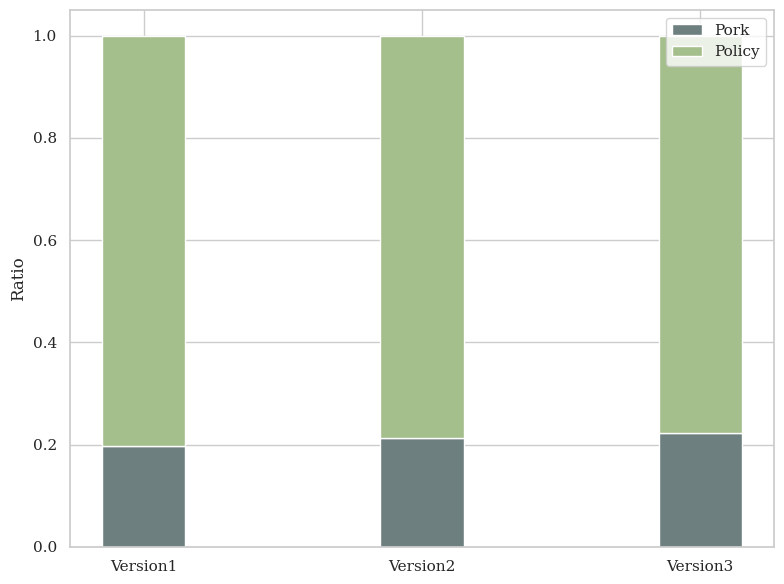

In [ ]:
plot_pork_policy_ratios(dfs=[topic_info['v1'], topic_info['v2'], topic_info['v3']],
                        titles=['Version1', 'Version2', 'Version3'],
                        save=False)

In [ ]:
# 首先，選取TH欄位中為6或7的資料
filtered_df = df_merge[df_merge['TH'].isin([6, 7])]
candidates_in_both = filtered_df.groupby('LNAME').filter(lambda x: x['TH'].nunique() == 2)
candidates_in_both.groupby('TH').size()

TH
6    123
7    123
dtype: int64

mean: 0.209, std: 0.149
mean: 0.317, std: 0.172


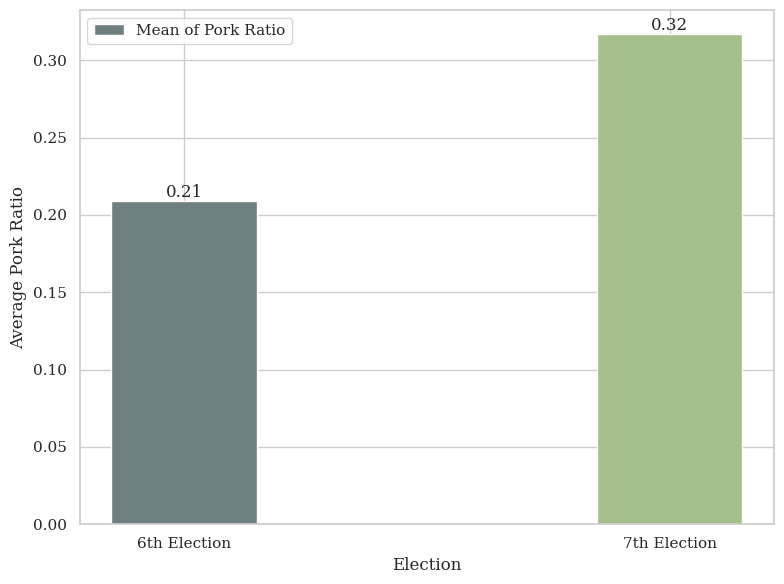

In [ ]:
plot_change(candidates_in_both, weight_cols, model=MODEL, save=True)

### 視覺化趨勢

In [19]:
plt.rcdefaults()
SAVE = True
AVG = True

Number of candidates: 2856
   TH      PORK
0   2  0.061473
1   3  0.097721
2   4  0.091086
3   5  0.107298
4   6  0.134625
5   7  0.176938
6   8  0.165345
7   9  0.109120
8  10  0.117904
9  11  0.134655


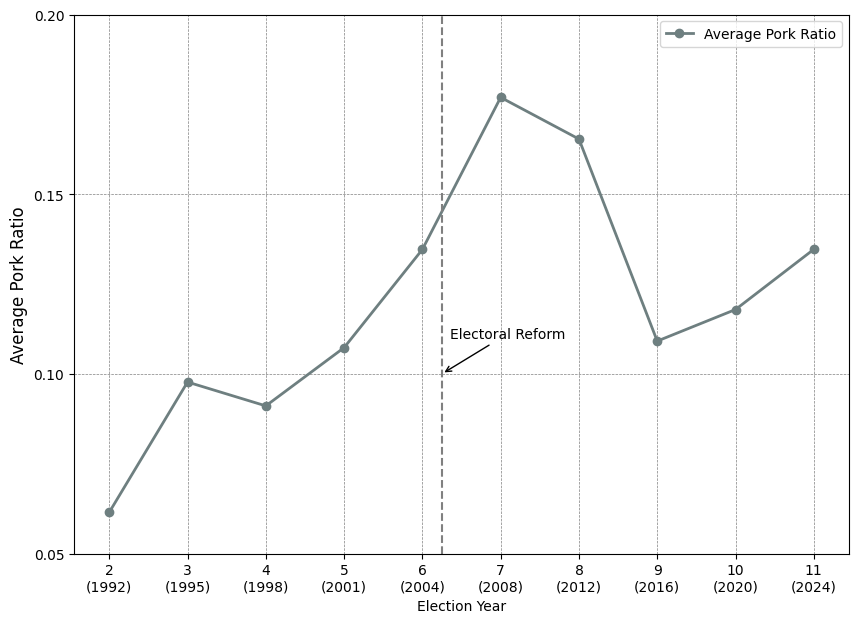

In [ ]:
%matplotlib inline
visualization(df=df_serious,
              model=MODEL,
              y_axis=0.1,
              party='Serious',
              columns=weight_cols,
              reform_year=2005,
              highlight=False,
              save=SAVE,
              avg=AVG) # 2856

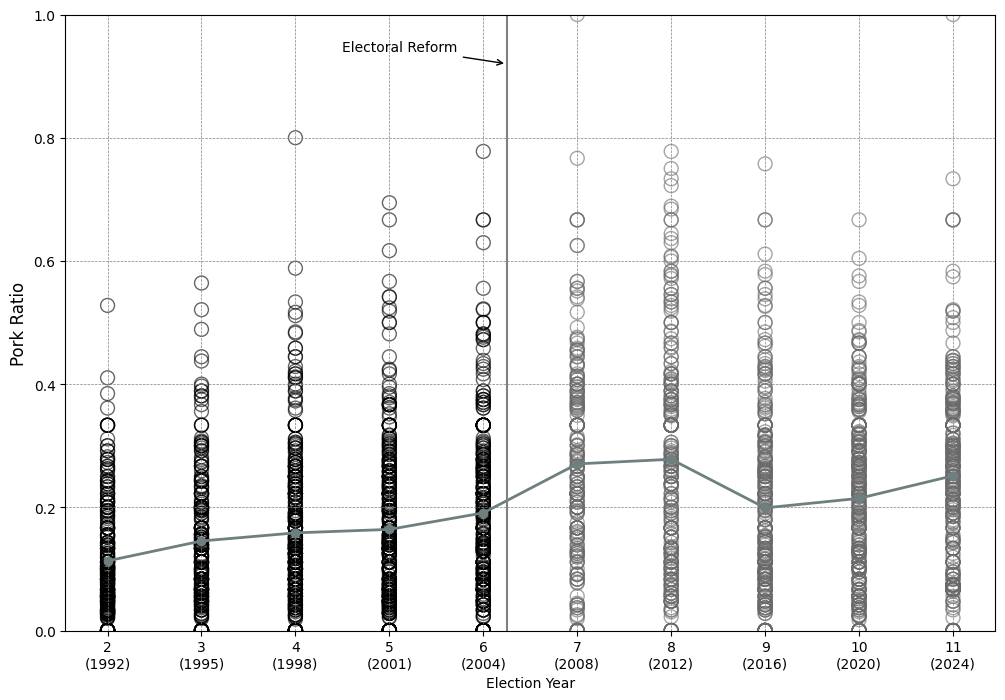

In [33]:
%matplotlib inline
visualization_dot_plot(df=df_serious,
                        model=MODEL,
                        party='Serious',
                        columns=equal_divided_cols,
                        save=SAVE
                       ) # 2856

Number of candidates: 2856
   TH      PORK
0   2  0.061591
1   3  0.095253
2   4  0.088408
3   5  0.103007
4   6  0.126924
5   7  0.167421
6   8  0.160978
7   9  0.107158
8  10  0.115070
9  11  0.128722


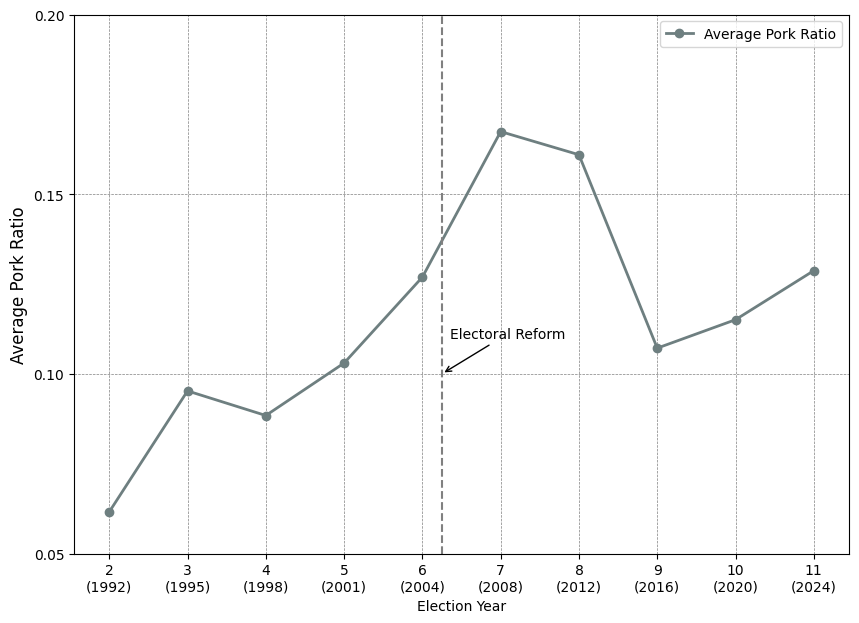

In [ ]:
%matplotlib inline
visualization(df=df_serious,
              model=MODEL,
              y_axis=0.1,
              party='Serious',
              columns=equal_divided_cols,
              reform_year=2005,
              save=SAVE,
              avg=True) # 2856

Number of candidates: 824
   TH      PORK
0   2  0.073785
1   3  0.114547
2   4  0.117785
3   5  0.117210
4   6  0.114800
5   7  0.173454
6   8  0.216069
7   9  0.160107
8  10  0.148632
9  11  0.135070


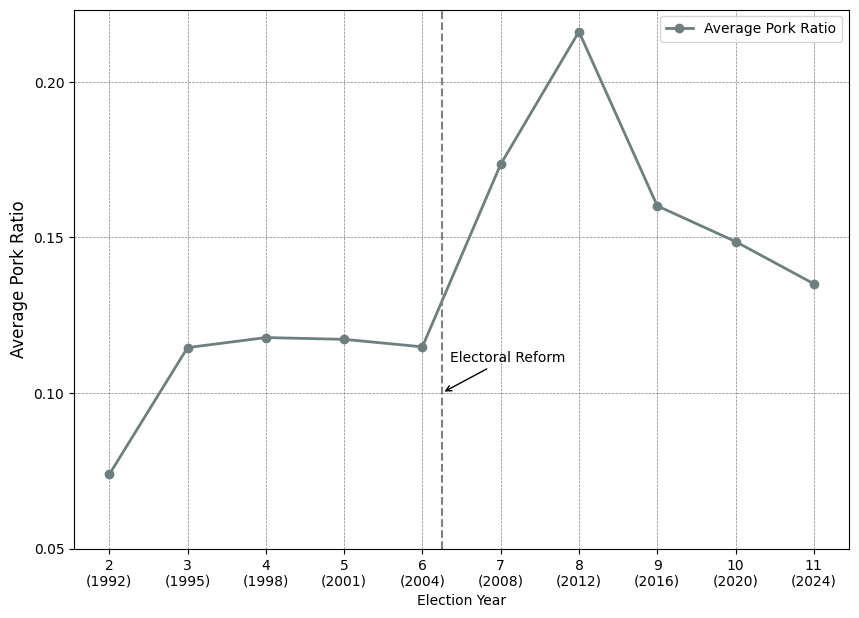

In [ ]:
# KMT serious candidates' electoral strategy
visualization(df=df_serious.query('PARTY_CODE == 1'),
              model=MODEL,
              y_axis=0.1,
              party='KMT',
              columns=equal_divided_cols,
              reform_year=2005,
              save=SAVE,
              avg=AVG) # 824

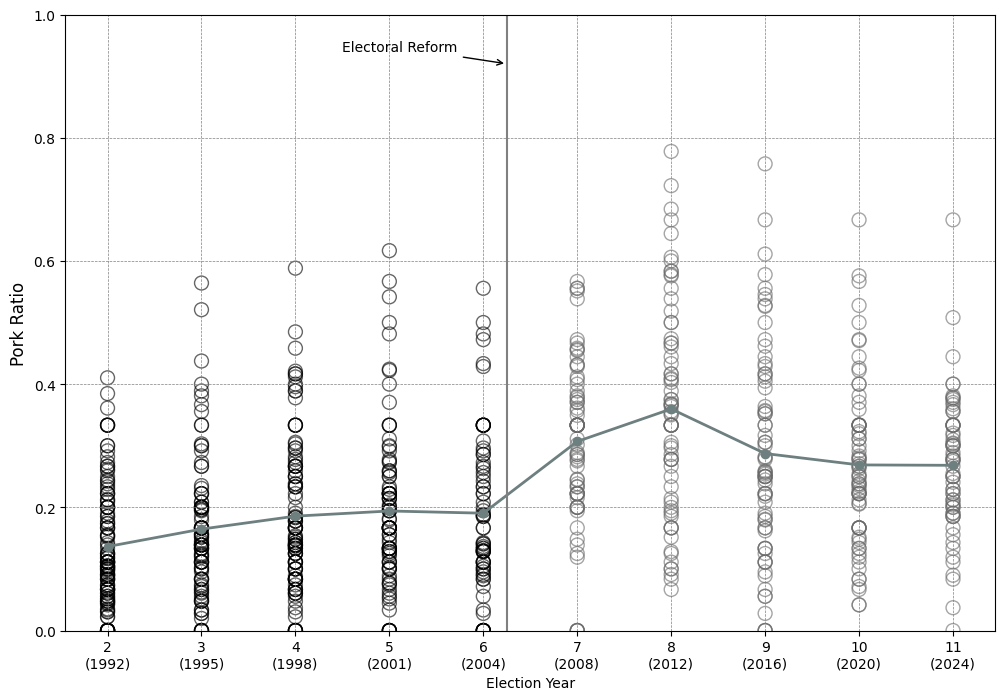

In [34]:
%matplotlib inline
visualization_dot_plot(df=df_serious.query('PARTY_CODE == 1'),
                        model=MODEL,
                        party='KMT',
                        columns=equal_divided_cols,
                        save=SAVE
                       )

Number of candidates: 710
   TH      PORK
0   2  0.062507
1   3  0.077691
2   4  0.068617
3   5  0.102817
4   6  0.137935
5   7  0.189048
6   8  0.172843
7   9  0.156717
8  10  0.171751
9  11  0.193435


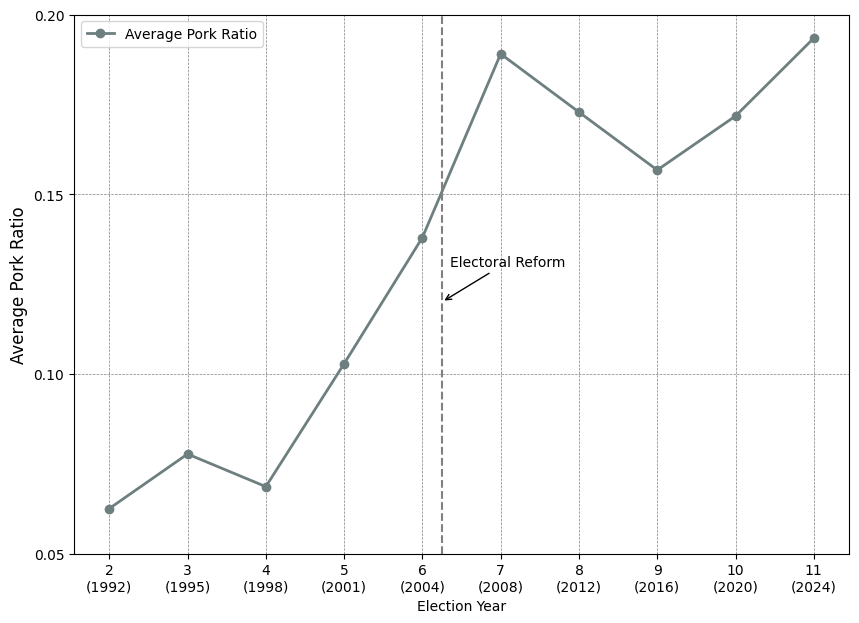

In [ ]:
# DPP serious candidates' electoral strategy
visualization(df=df_serious.query('PARTY_CODE == 2'),
              model=MODEL,
              y_axis=0.12,
              party='DPP',
              columns=equal_divided_cols,
              reform_year=2005,
              save=SAVE,
              avg=AVG) # 710

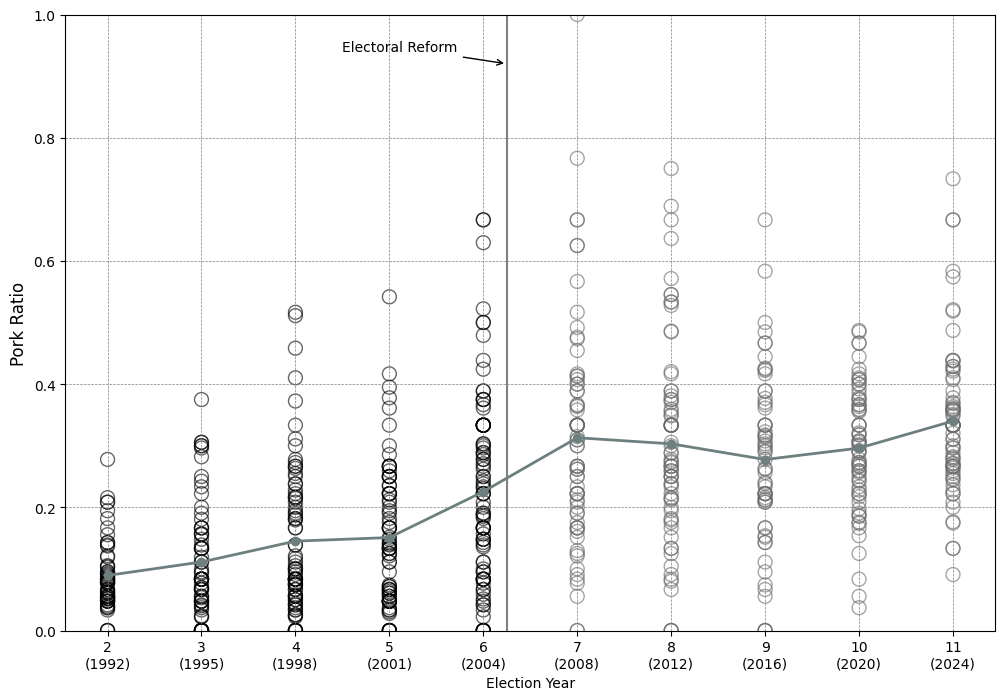

In [35]:
%matplotlib inline
visualization_dot_plot(df=df_serious.query('PARTY_CODE == 2'),
                        model=MODEL,
                        party='DPP',
                        columns=equal_divided_cols,
                        save=SAVE
                       )

Number of candidates: 1322
   TH      PORK
0   2  0.046890
1   3  0.088574
2   4  0.078409
3   5  0.096784
4   6  0.125922
5   7  0.139267
6   8  0.113152
7   9  0.062218
8  10  0.079752
9  11  0.092637


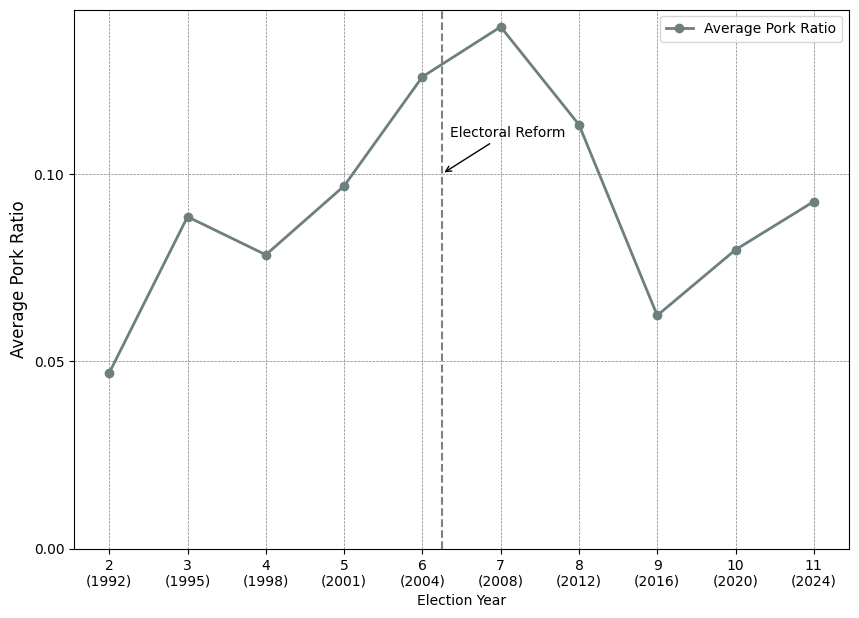

In [ ]:
# Non KMT & DPP serious candidates' electoral strategy
visualization(df=df_serious.query('PARTY_CODE > 2'),
              model=MODEL,
              y_axis=0.1,
              party='Non-KMT&DPP',
              columns=equal_divided_cols,
              reform_year=2005,
              save=SAVE,
              avg=AVG) # 1322

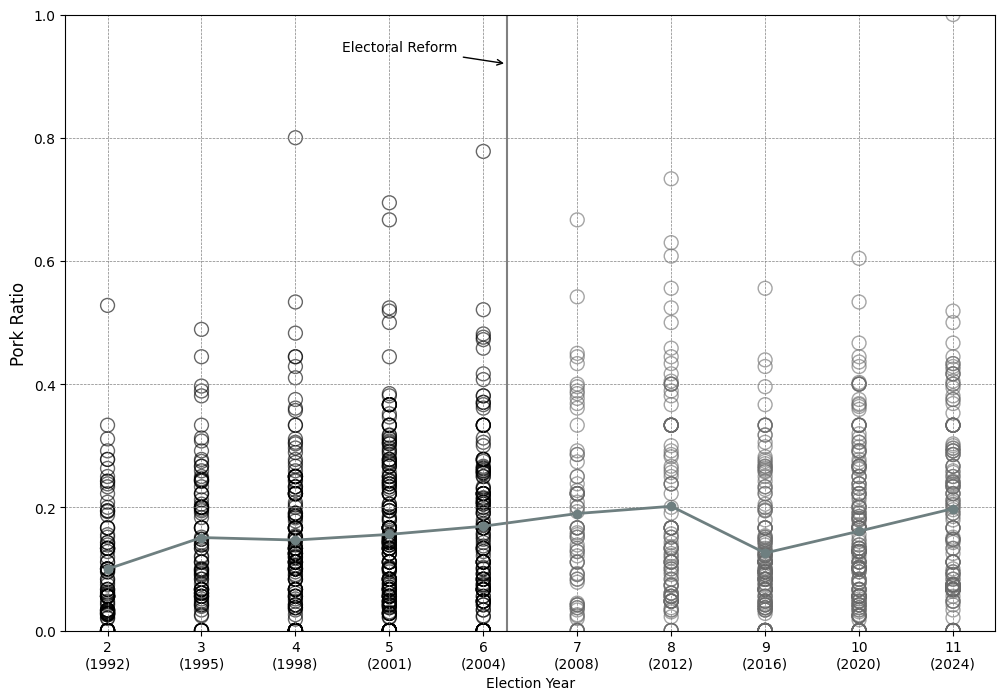

In [36]:
%matplotlib inline
visualization_dot_plot(df=df_serious.query('PARTY_CODE > 2'),
                        model=MODEL,
                        party='Non-KMT&DPP',
                        columns=equal_divided_cols,
                        save=SAVE
                       )

## Model Validation and Visualization

## T test

In [ ]:
t_stat, p_value = perform_t_test(df=candidates_in_both,
                                 columns=weight_cols,
                                 candidate='連任候選人'
                                 )

Shapiro-Wilk Test: Stat= 0.80110102891922 , p-value= 1.2899371674979232e-11
資料可能不是常態分佈
Shapiro-Wilk Test: Stat= 0.8666913509368896 , p-value= 3.9375396276852825e-09
資料可能不是常態分佈
Mann-Whitney U test: U stat= 5695.0 , p-value= 0.0007937924897652636

連任候選人間存在顯著差異。

TtestResult(statistic=-2.186267330039659, pvalue=0.014878542150944769, df=241.3482393989037)
ConfidenceInterval(low=-inf, high=-0.010372613372123862)

第六屆平均: 0.147, 第六屆標準差: 0.159 
第七屆平均: 0.189, 第七屆標準差: 0.143 

連任候選人間存在顯著差異。


In [ ]:
t_stat, p_value = perform_t_test(df=df_serious,
                                 columns=weight_cols,
                                 candidate='認真型候選人')

Shapiro-Wilk Test: Stat= 0.7674400210380554 , p-value= 2.1911894873081795e-20
資料可能不是常態分佈
Shapiro-Wilk Test: Stat= 0.8816170692443848 , p-value= 1.1378412101414881e-11
資料可能不是常態分佈
Mann-Whitney U test: U stat= 24280.5 , p-value= 1.7050005809424628e-05

認真型候選人間存在顯著差異。

TtestResult(statistic=-2.9931651525782614, pvalue=0.0014554625608535923, df=456.0876876595583)
ConfidenceInterval(low=-inf, high=-0.01901319763680307)

第六屆平均: 0.135, 第六屆標準差: 0.161 
第七屆平均: 0.177, 第七屆標準差: 0.153 

認真型候選人間存在顯著差異。


In [ ]:
t_stat, p_value = perform_t_test(df=df_serious[df_serious['PARTY_CODE'] == 1],
                                 columns=weight_cols,
                                 candidate='國民黨候選人')

print(f"國民黨提名人數: {len(df_serious[df_serious['PARTY_CODE'] == 1])}")
print(f"第六屆國民黨提名人數: {len(df_serious.query('PARTY_CODE == 1 and TH == 6'))}")
print(f"第七屆國民黨提名人數: {len(df_serious.query('PARTY_CODE == 1 and TH == 7'))}")

Shapiro-Wilk Test: Stat= 0.8552828431129456 , p-value= 9.888226486509666e-07
資料可能不是常態分佈
Shapiro-Wilk Test: Stat= 0.9487659335136414 , p-value= 0.0062514967285096645
資料可能不是常態分佈
Mann-Whitney U test: U stat= 1570.0 , p-value= 0.00024106870541211432

國民黨候選人間存在顯著差異。

TtestResult(statistic=-3.0784254731565435, pvalue=0.0012564540170805424, df=137.43806208335587)
ConfidenceInterval(low=-inf, high=-0.027694499173370767)

第六屆平均: 0.119, 第六屆標準差: 0.118 
第七屆平均: 0.179, 第七屆標準差: 0.111 

國民黨候選人間存在顯著差異。
國民黨提名人數: 824
第六屆國民黨提名人數: 70
第七屆國民黨提名人數: 70


In [ ]:
t_stat, p_value = perform_t_test(df=df_serious[df_serious['PARTY_CODE'] == 2],
                                 columns=weight_cols,
                                 candidate='民進黨候選人')

print(f"民進黨提名人數: {len(df_serious[df_serious['PARTY_CODE'] == 2])}")
print(f"民進黨提名人數: {len(df_serious.query('PARTY_CODE == 2 and TH == 6'))}")
print(f"民進黨提名人數: {len(df_serious.query('PARTY_CODE == 2 and TH == 7'))}")

Shapiro-Wilk Test: Stat= 0.8081008195877075 , p-value= 1.8149819425161695e-09
資料可能不是常態分佈
Shapiro-Wilk Test: Stat= 0.9428585171699524 , p-value= 0.0033913888037204742
資料可能不是常態分佈
Mann-Whitney U test: U stat= 2199.0 , p-value= 0.0016120101627636538

民進黨候選人間存在顯著差異。

TtestResult(statistic=-2.1593416966587218, pvalue=0.016172853268653725, df=156.60563372983464)
ConfidenceInterval(low=-inf, high=-0.012192116599475784)

第六屆平均: 0.149, 第六屆標準差: 0.168 
第七屆平均: 0.201, 第七屆標準差: 0.135 

民進黨候選人間存在顯著差異。
民進黨提名人數: 710
民進黨提名人數: 90
民進黨提名人數: 69


In [ ]:
t_stat, p_value = perform_t_test(df=df_serious[df_serious['PARTY_CODE'] > 2],
                                 columns=weight_cols,
                                 candidate='小黨候選人')

print(f"小黨提名人數: {len(df_serious[df_serious['PARTY_CODE'] > 2])}")
print(f"小黨提名人數: {len(df_serious.query('PARTY_CODE > 2 and TH == 6'))}")
print(f"小黨提名人數: {len(df_serious.query('PARTY_CODE > 2 and TH == 7'))}")


Shapiro-Wilk Test: Stat= 0.7234193682670593 , p-value= 4.9226658041740326e-15
資料可能不是常態分佈
Shapiro-Wilk Test: Stat= 0.7557623386383057 , p-value= 2.721119551907236e-09
資料可能不是常態分佈
Mann-Whitney U test: U stat= 4717.5 , p-value= 0.7869365382008968

小黨候選人間不存在顯著差異。

TtestResult(statistic=-0.6046397187418848, pvalue=0.546586077425355, df=117.31468463538913)
ConfidenceInterval(low=-0.07297669738608532, high=0.03883815442711082)

第六屆平均: 0.133, 第六屆標準差: 0.173 
第七屆平均: 0.15, 第七屆標準差: 0.198 

小黨候選人間不存在顯著差異。
小黨提名人數: 1322
小黨提名人數: 142
小黨提名人數: 68
